# On the stability of Eigenvector estimation with financial data
### Francisco A. Ibanez

- The unstability in the SVD comes from its sensitivity to non-normal observations and outliers
- The previous is very common in financial data
- Any financial methodology based on the SVD will suffer from this
- The last eigenvectors tend to be less stable over time and more sentitive to noise
- Truncating the SVD could improve the overall stability of financial methodologies based on this decomposition
- What about RPCA?
- I will measure the stability of the SVD over time by running rolling windows and measuring the angle between these resulting vectors, for each eigenvector
- If this is correct, I should see more similarity in the first eigenvectors over time, while the latter eigenvectors should show more variability

<AxesSubplot:xlabel='date'>

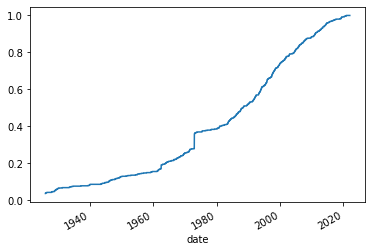

In [1]:
import pandas as pd

rt = pd.read_pickle('rt_sp.pkl')
is_tradable = pd.read_pickle('is_tradable_sp.pkl')
is_tradable = is_tradable.resample('BM').bfill()
is_tradable.columns = [int(x) for x in is_tradable.columns]
rt.columns = [int(x) for x in rt.columns]
sample_names = is_tradable.columns[is_tradable.loc['2021-12-31']]  # Most recent set

# Data availability and time series drop-threshold setting
rt[sample_names].ffill().count(axis=1).div(len(sample_names)).plot()

In [4]:
# Sometime during the late 70's more than 40% of the data is available
thresh_dt = '1989-12-31'

data = rt[sample_names]
first_dt = data.apply(pd.Series.first_valid_index)
too_short = first_dt[first_dt > thresh_dt].index
data = data.drop(too_short, axis=1).dropna()
print(str(int(data.shape[1])), 'stocks in the data set.')

263 stocks in the data set.


In [72]:
from scipy.linalg import svd
import numpy as np
from sklearn import preprocessing
from tqdm import tqdm

window = pd.DateOffset(years=5)  # Also, shorter windows should mean more noise
idx = data.loc[data.index[0] + window:].index  # Should be weekly/monthly instead?
# TODO: the bootstrapping could also include sampling different stocks (see video palomar)
collect = []
for dt in tqdm(idx):
    sample = data.loc[dt - window:dt].dropna()
    scaler = preprocessing.StandardScaler().fit(sample)
    sample_z = scaler.transform(sample)

    U, s, Vt = svd(
        sample_z,
        full_matrices=False,
        compute_uv=True,
        lapack_driver='gesdd'
    )
    V = Vt.T
    df = pd.DataFrame(V)
    df.index = pd.MultiIndex.from_tuples([(dt, x) for x in df.index])
    collect += [df]

eig = pd.concat(collect, axis=0)

100%|██████████| 5868/5868 [04:52<00:00, 20.09it/s]


In [76]:
from scipy.spatial import distance

cossim = pd.DataFrame(columns=eig.columns, index=idx)
for dt1 in tqdm(idx[1:]):
    dt0 = cossim.index[cossim.index.get_loc(dt1) - 1]
    eig_t0 = eig.loc[dt0]
    eig_t1 = eig.loc[dt1]
    for i in eig.columns:
        v0 = eig_t0[i]
        v1 = eig_t1[i]
        cossim.loc[dt1, i] = min(distance.cosine(v0, v1), distance.cosine(v0, -v1))


100%|██████████| 5867/5867 [09:30<00:00, 10.29it/s]


In [69]:
cossim

,0,1,2,3,4,5,6,7,8,9,...,253,254,255,256,257,258,259,260,261,262
date,,,,,,,,,,,,,,,,,,,,,
2019-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30,0.000001,0.000011,0.000051,0.000003,0.000015,0.000035,0.000022,0.000036,0.00011,0.00004,...,0.012284,0.000036,0.000867,0.002228,0.002743,0.001446,0.000169,0.001229,0.001212,0.00057
2019-10-31,0.000001,0.000011,0.000007,0.000016,0.000041,0.00011,0.000071,0.00021,0.000097,0.000039,...,0.014551,0.12679,0.162605,0.028812,0.012695,0.003698,0.000712,0.002599,0.003395,0.000098
2019-11-01,0.000002,0.000012,0.000063,0.000036,0.000007,0.000434,0.000404,0.000076,0.000386,0.000257,...,0.000436,0.027918,0.032324,0.001191,0.010881,0.003447,0.003295,0.004808,0.000479,0.000284
2019-11-04,0.000001,0.000029,0.000092,0.000012,0.00006,0.000135,0.000265,0.000089,0.001147,0.000965,...,0.001384,0.007384,0.003976,0.000989,0.000128,0.000567,0.000072,0.000113,0.0001,0.000307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30,0.0,0.0,0.000001,0.000001,0.000002,0.000001,0.000026,0.000004,0.000008,0.000001,...,0.002133,0.000941,0.000634,0.000648,0.000783,0.000062,0.000073,0.000385,0.000517,0.00007
2020-12-31,0.0,0.000001,0.0,0.000001,0.000011,0.000026,0.000027,0.000027,0.000022,0.000001,...,0.000372,0.00029,0.000036,0.000123,0.000058,0.000117,0.000279,0.000324,0.00031,0.000151
2021-01-04,0.000001,0.000004,0.000008,0.000024,0.0001,0.000006,0.000085,0.000075,0.00001,0.000616,...,0.005006,0.000602,0.001507,0.001036,0.000221,0.000142,0.00046,0.000092,0.000044,0.000066


<AxesSubplot:xlabel='date'>

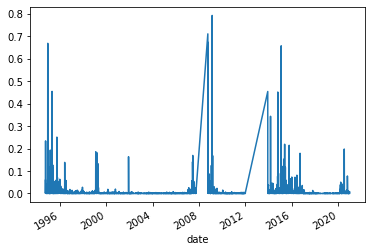

In [77]:
cossim[cossim.shape[1] - 1].plot()

<AxesSubplot:xlabel='date'>

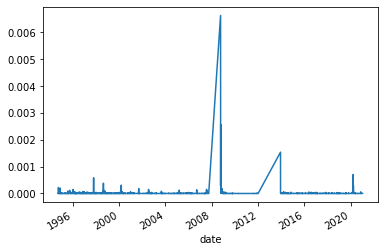

In [78]:
cossim[0].plot()